<a href="https://colab.research.google.com/github/Taenyoung-Lee/2023-S-S-ML1/blob/main/%ED%97%8C%ED%98%88_%EC%88%98%EC%9A%94_%EA%B3%B5%EA%B8%89_%EB%B6%84%EC%84%9D%EB%B3%B4%EA%B3%A0%EC%84%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import warnings
import itertools

data view

In [ ]:
import chardet

with open('C:/Users/galax/Downloads/bddata.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

{'encoding': 'EUC-KR', 'confidence': 0.99, 'language': 'Korean'}


In [ ]:
df = pd.read_csv('C:/Users/galax/Downloads/bddata.csv',encoding='EUC-KR')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   시점      216 non-null    int64 
 1   월별(1)   216 non-null    object
 2   혈액보유    216 non-null    int64 
 3   혈액공급    216 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.9+ KB


In [ ]:
df['blood_demand'] =df['혈액공급'] - df['혈액보유']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   시점            216 non-null    int64 
 1   월별(1)         216 non-null    object
 2   혈액보유          216 non-null    int64 
 3   혈액공급          216 non-null    int64 
 4   blood_demand  216 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 8.6+ KB


시점데이터 통합&변환

In [ ]:
df['date'] = pd.date_range('2005-01', periods=(18*12), freq='M')
df = df.set_index("date")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2005-01-31 to 2022-12-31
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   시점            216 non-null    int64 
 1   월별(1)         216 non-null    object
 2   혈액보유          216 non-null    int64 
 3   혈액공급          216 non-null    int64 
 4   blood_demand  216 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.1+ KB


In [ ]:
df_imputed =df[['혈액공급','혈액보유', 'blood_demand']]
df_imputed

,혈액공급,혈액보유,blood_demand
date,,,
2005-01-31,295201,28590,266611
2005-02-28,248238,27736,220502
2005-03-31,289939,29314,260625
2005-04-30,289119,33814,255305
2005-05-31,305595,32489,273106
...,...,...,...
2022-08-31,358327,22839,335488
2022-09-30,365809,26582,339227
2022-10-31,357967,21567,336400


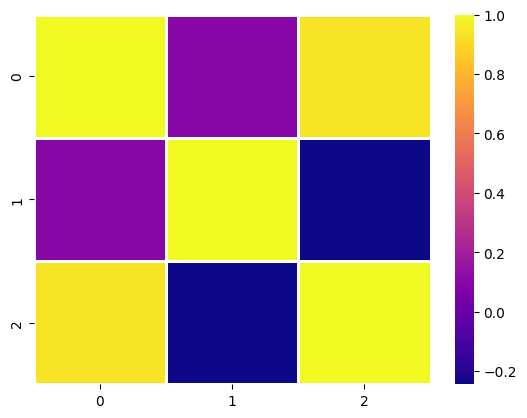

In [ ]:
corr_mat=np.corrcoef(df_imputed,rowvar=False)
sns.heatmap(corr_mat,linewidth=1,cmap='plasma')
plt.show()

수요 시계열 분석

In [ ]:
df_t = df_imputed['blood_demand']

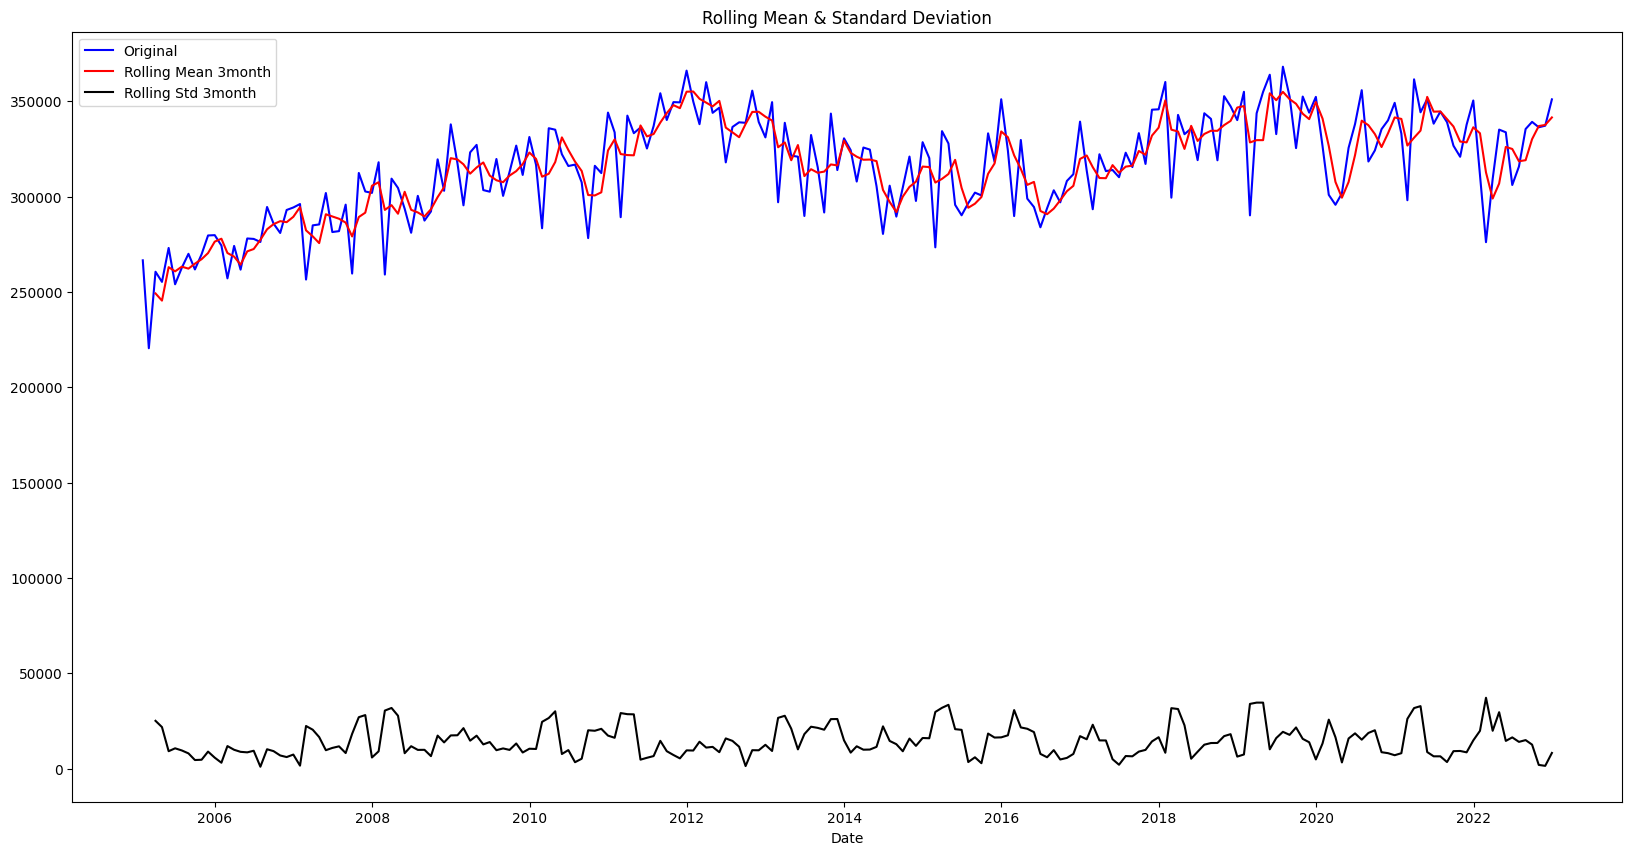

In [ ]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean {}month'.format(interval))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std {}month'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

plot_rolling(df_t,3)

ADF test (데이터의 정상성 확인)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST 결과')
adf_test(df_t)

ADF TEST 결과
ADF Statistics: -2.419026
p-value: 0.136438
num of lags: 13.000000
num of observations: 202.000000
Critical values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


p-value > 0.05 이므로 해당 data는 비정상성 data

In [ ]:
import pmdarima as pm
from pmdarima.arima import ndiffs

n_diffs = ndiffs(df_t, alpha=0.05, test='adf', max_d=6)
print(f"추정된 차수 d = {n_diffs}") # 결과

추정된 차수 d = 1


In [ ]:
import pmdarima as pm

model = pm.auto_arima(
            y=df_t,
            d=1,
            start_p=0, max_p=3,
            start_q=0, max_q=3,
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4938.092, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4890.174, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4879.764, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4936.156, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4881.816, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4882.391, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4878.984, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4881.008, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4881.135, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4888.618, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.29 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.125 seconds


ARiMA data 훈련과 test

In [ ]:
# train : test = 9 : 1
train_data, test_data = df_t[:int(len(df_t)*0.9)], df_t[int(len(df_t)*0.9):]

from statsmodels.tsa.arima_model import ARIMA

model_fit = pm.auto_arima(
    	    y=train_data,
 	        d=1 ,
            start_p=0, max_p=2,
            start_q=0, max_q=2,
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4434.540, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4387.515, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4381.944, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4432.552, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4383.668, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4383.967, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4380.851, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4382.527, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4382.547, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4385.788, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.051 seconds
                               SARIMAX Results                                
Dep. Variable:     

test data 와 예측값 비교

In [ ]:
# forecast 함수
def forecast_n_step(model, n = (1)):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    # print("fc", fc,"conf_int", conf_int)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower



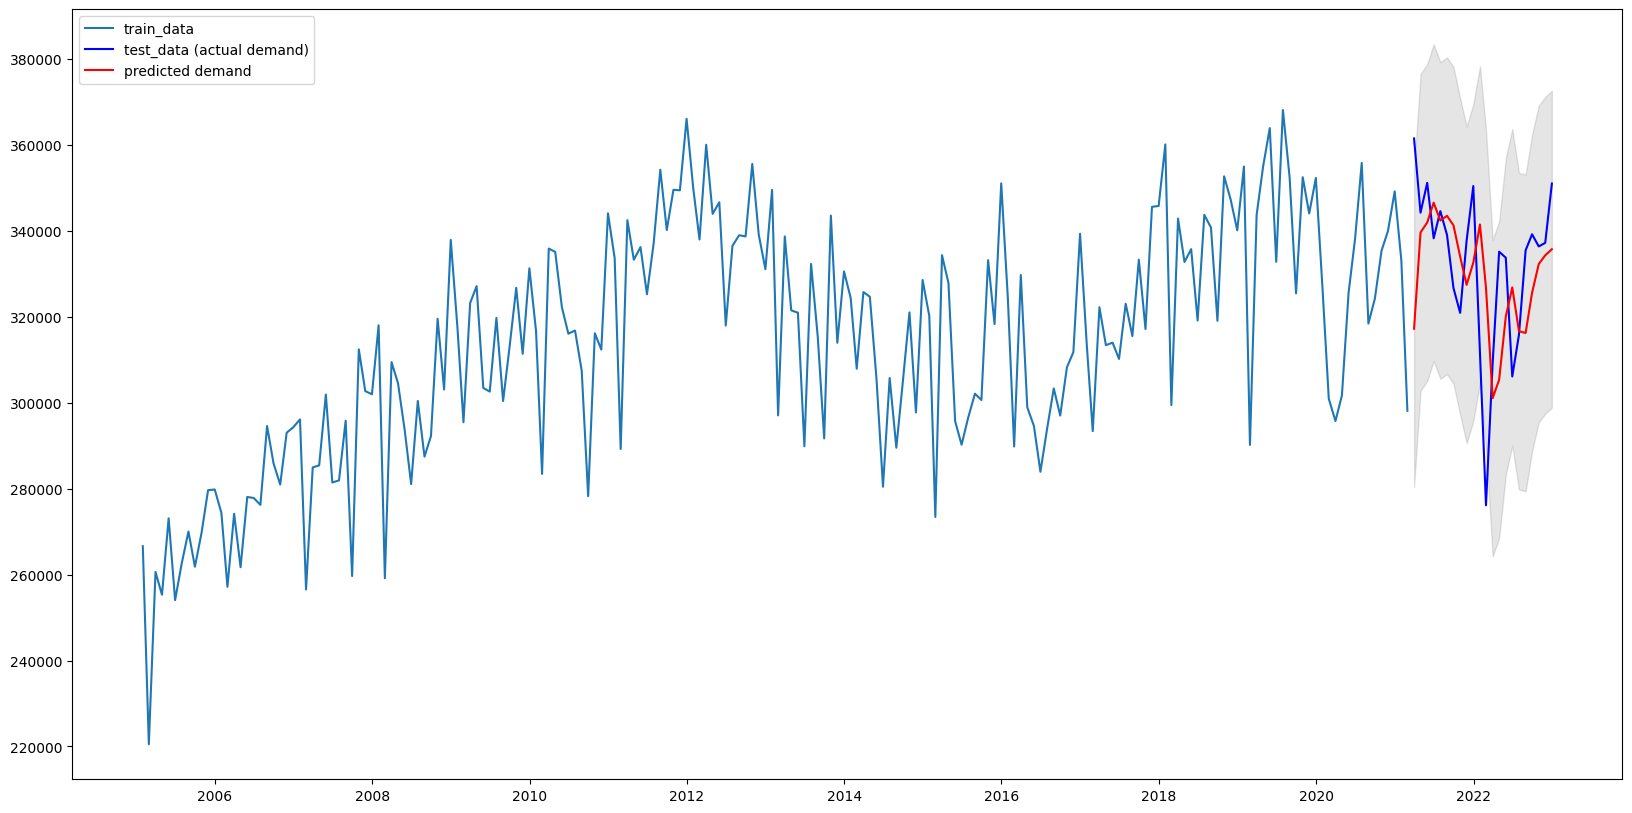

In [ ]:
# Forecast
fc, upper, lower = forecast(len(test_data), model_fit, test_data.index, data = test_data)

# pandas series 생성
# fc # 예측결과
lower_series = pd.Series(lower, index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(upper, index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(20,10))
plt.plot(train_data, label='train_data')
plt.plot(test_data, c='b', label='test_data (actual demand)')
plt.plot(fc, c='r',label='predicted demand')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend(loc='upper left')
plt.show()

향후 7년 수요량 예측

2023-01-31    343295.952172
2023-02-28    343295.952172
2023-03-31    343295.952172
2023-04-30    343295.952172
2023-05-31    343295.952172
                  ...      
2029-08-31    343295.952172
2029-09-30    343295.952172
2029-10-31    343295.952172
2029-11-30    343295.952172
2029-12-31    343295.952172
Freq: M, Length: 84, dtype: float64


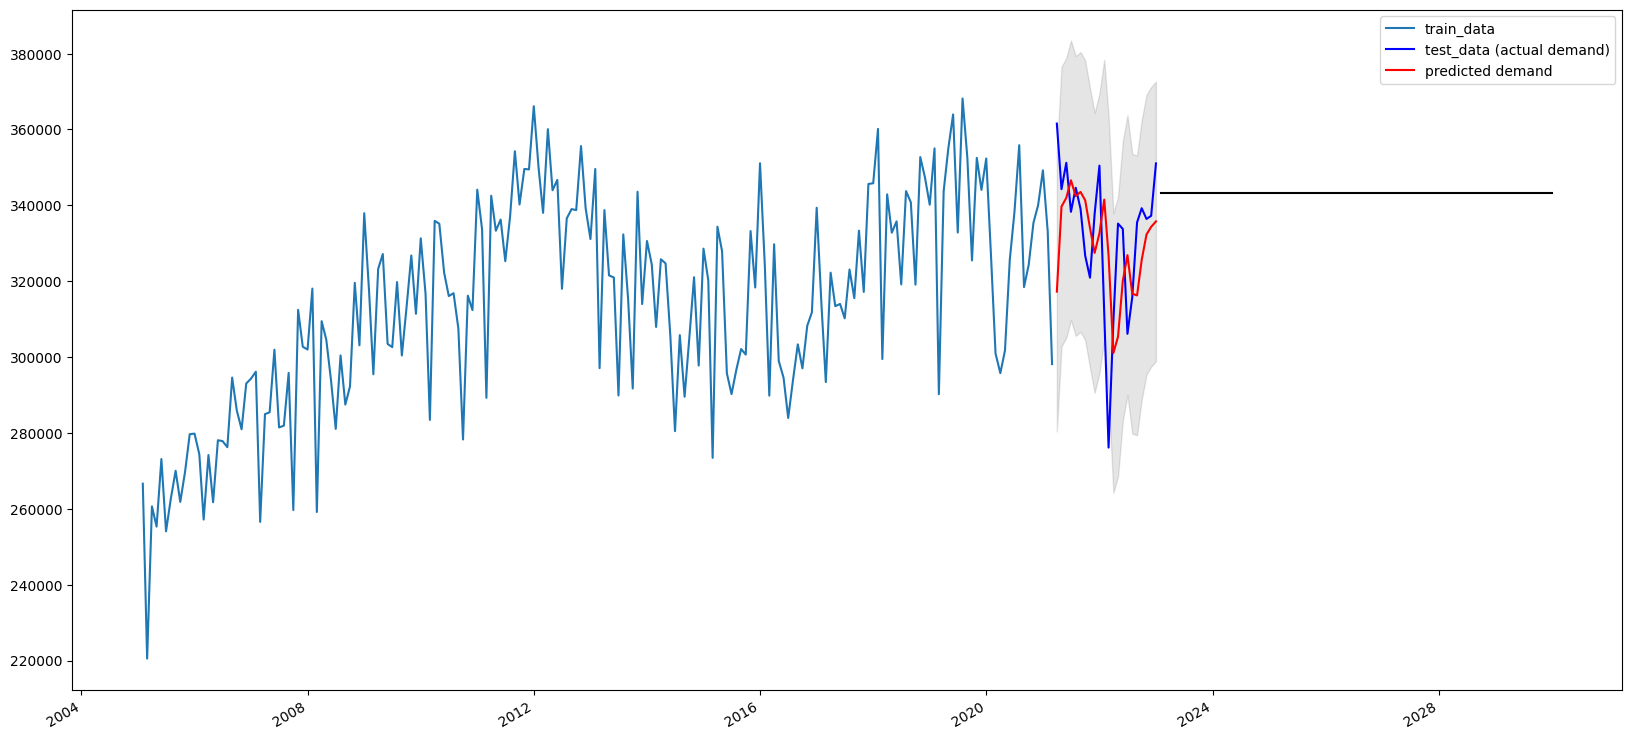

In [ ]:
date_index = pd.date_range('2023-01', periods=(7*12), freq='M')
fcast2 = model.predict(7*12)
fcast2 = pd.Series(fcast2, index=date_index)
print(fcast2)
plt.figure(figsize=(20,10))
plt.plot(train_data, label='train_data')
plt.plot(test_data, c='b', label='test_data (actual demand)')
plt.plot(fc, c='r',label='predicted demand')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend(loc='upper left')
fcast2.plot(color='black')
plt.show()



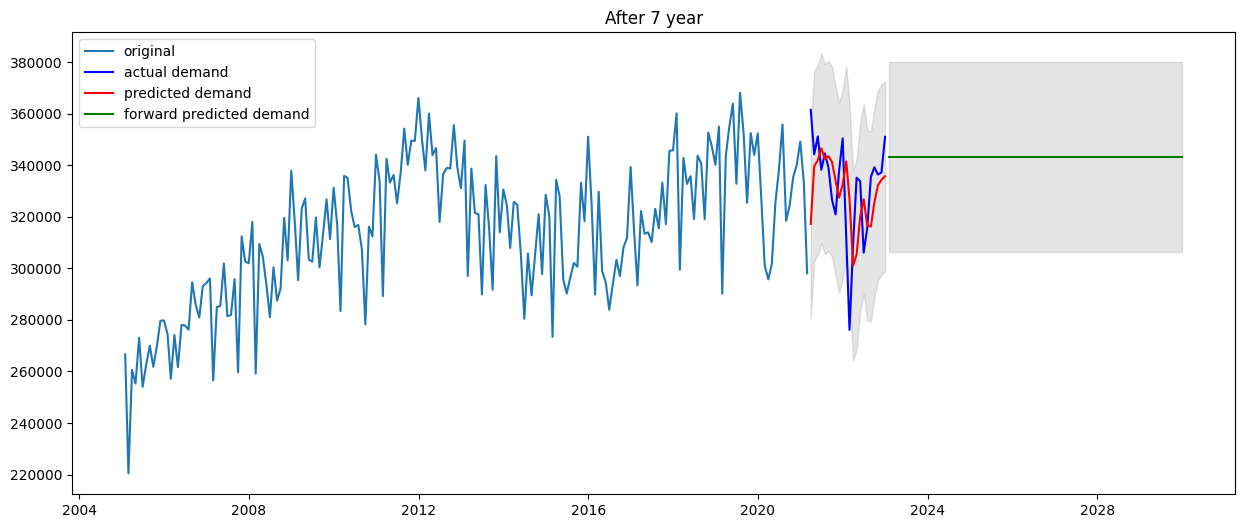

In [ ]:
date_index = pd.date_range('2023-01', periods=(7*12), freq='M')

fc2, upper2, lower2 = forecast(len(date_index), model_fit, date_index)

#print('7년후 혈액 수요')
#print(fc2.tail())
# fc2, conf = forecast_n_step(model_fit, len(date_list))
lower_series2 = pd.Series(lower2, index=date_index)  # 예측결과의 하한 바운드
upper_series2 = pd.Series(upper2, index=date_index)  # 예측결과의 상한 바운드
# plot
plt.figure(figsize=(15,6))
plt.plot(train_data, label='original')
plt.plot(test_data, c='b', label='actual demand')
plt.plot(fc, c='r',label='predicted demand')
plt.plot(fc2, c='g',label='forward predicted demand')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.10)
plt.title('After 7 year')
plt.legend(loc='upper left')
plt.show()

SARiMA 통한 분석

In [ ]:

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_t,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue



ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6058.505789872093
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5589.321641033315
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4610.764379998063
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4337.185090571241
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4630.696217754321
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4609.639443638822
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4356.1803177897
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:4332.88760959931
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:5880.42431073606
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5514.890529949871
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:4558.238176629464
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:4287.271371400335
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:5550.481981913098
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:5498.0859048080365
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:4325.583677933613
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:4283.705140856481
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:4910.273500595332
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4587.24060856665
ARIMA(0, 1, 0)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df_t,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1494      0.135     -1.106      0.269      -0.414       0.115
ma.L1         -0.5154      0.118     -4.363      0.000      -0.747      -0.284
ar.S.L12      -0.1440      0.146     -0.986      0.324      -0.430       0.142
ma.S.L12      -0.3621      0.099     -3.668      0.000      -0.556      -0.169
sigma2      3.003e+08   1.31e-10    2.3e+18      0.000       3e+08       3e+08


In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
pred_ci = pred.conf_int()

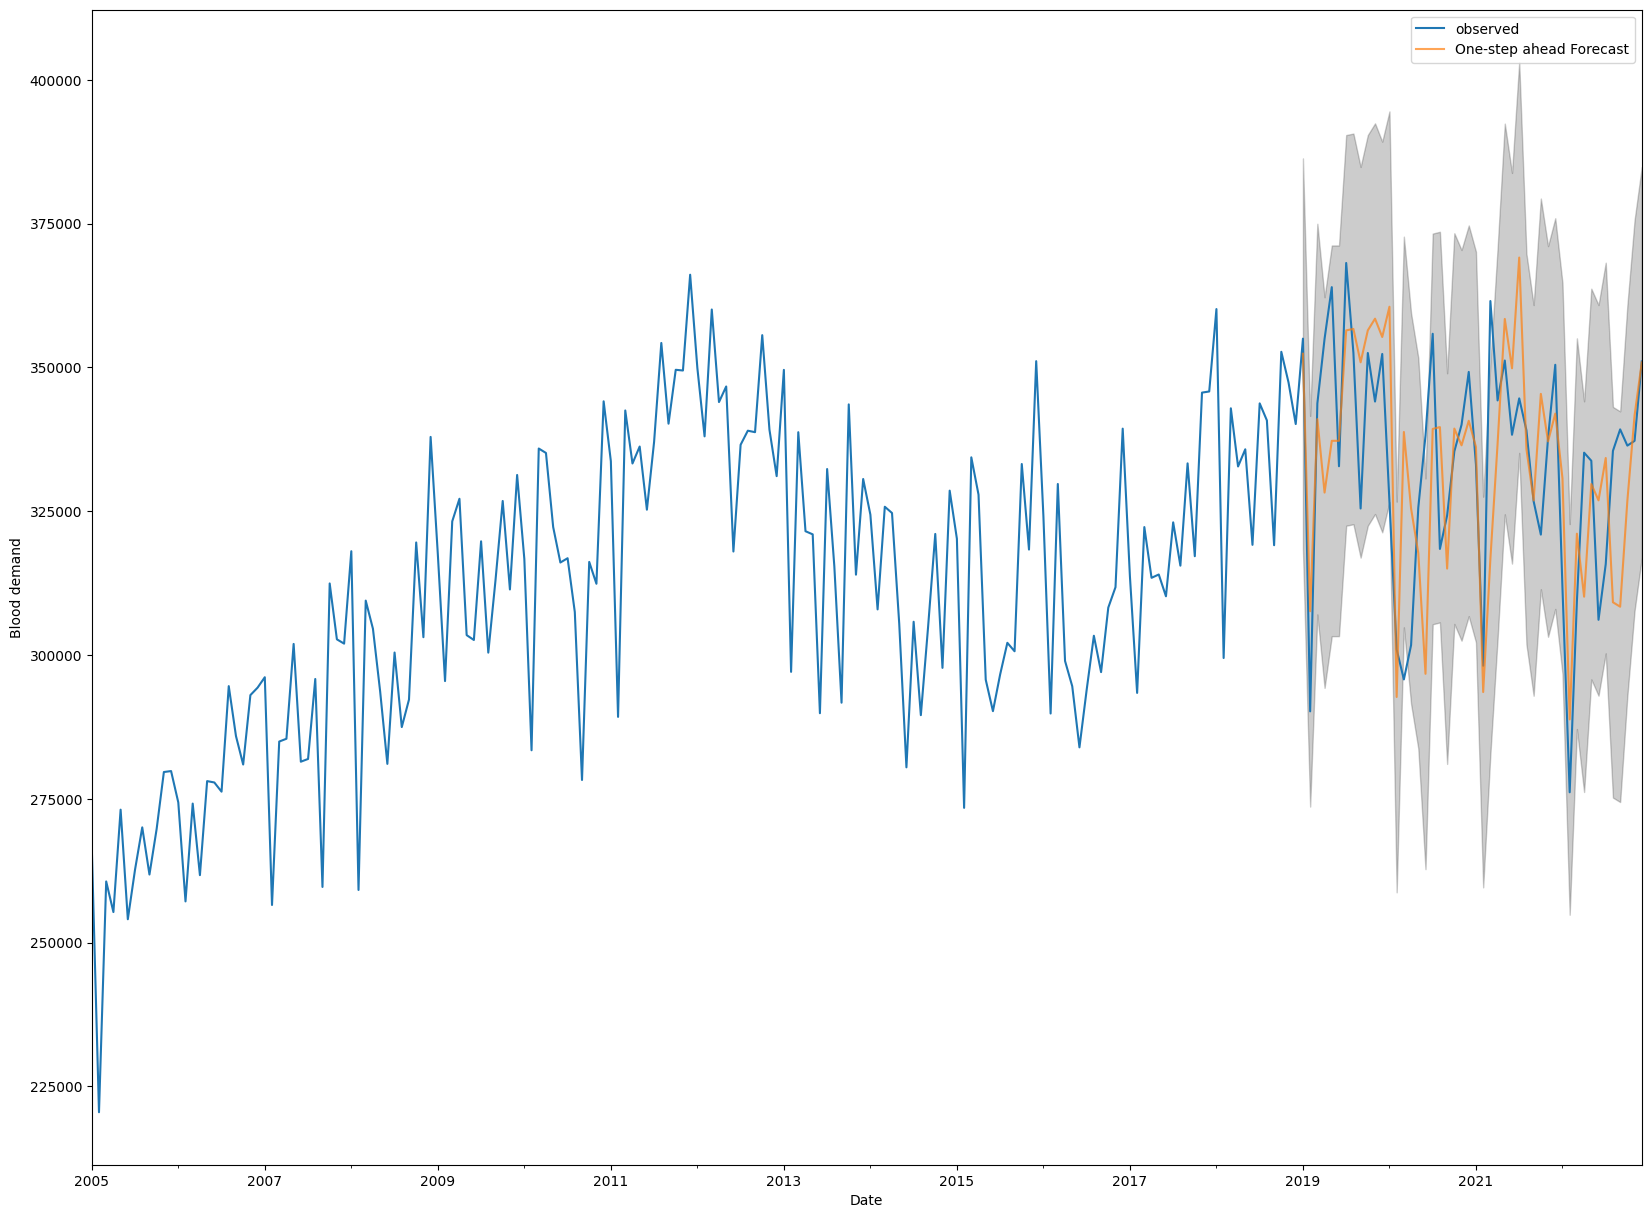

In [ ]:
plt.figure(figsize=(20,15))
ax = df_t['2005':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Blood demand')
plt.legend()

plt.show()

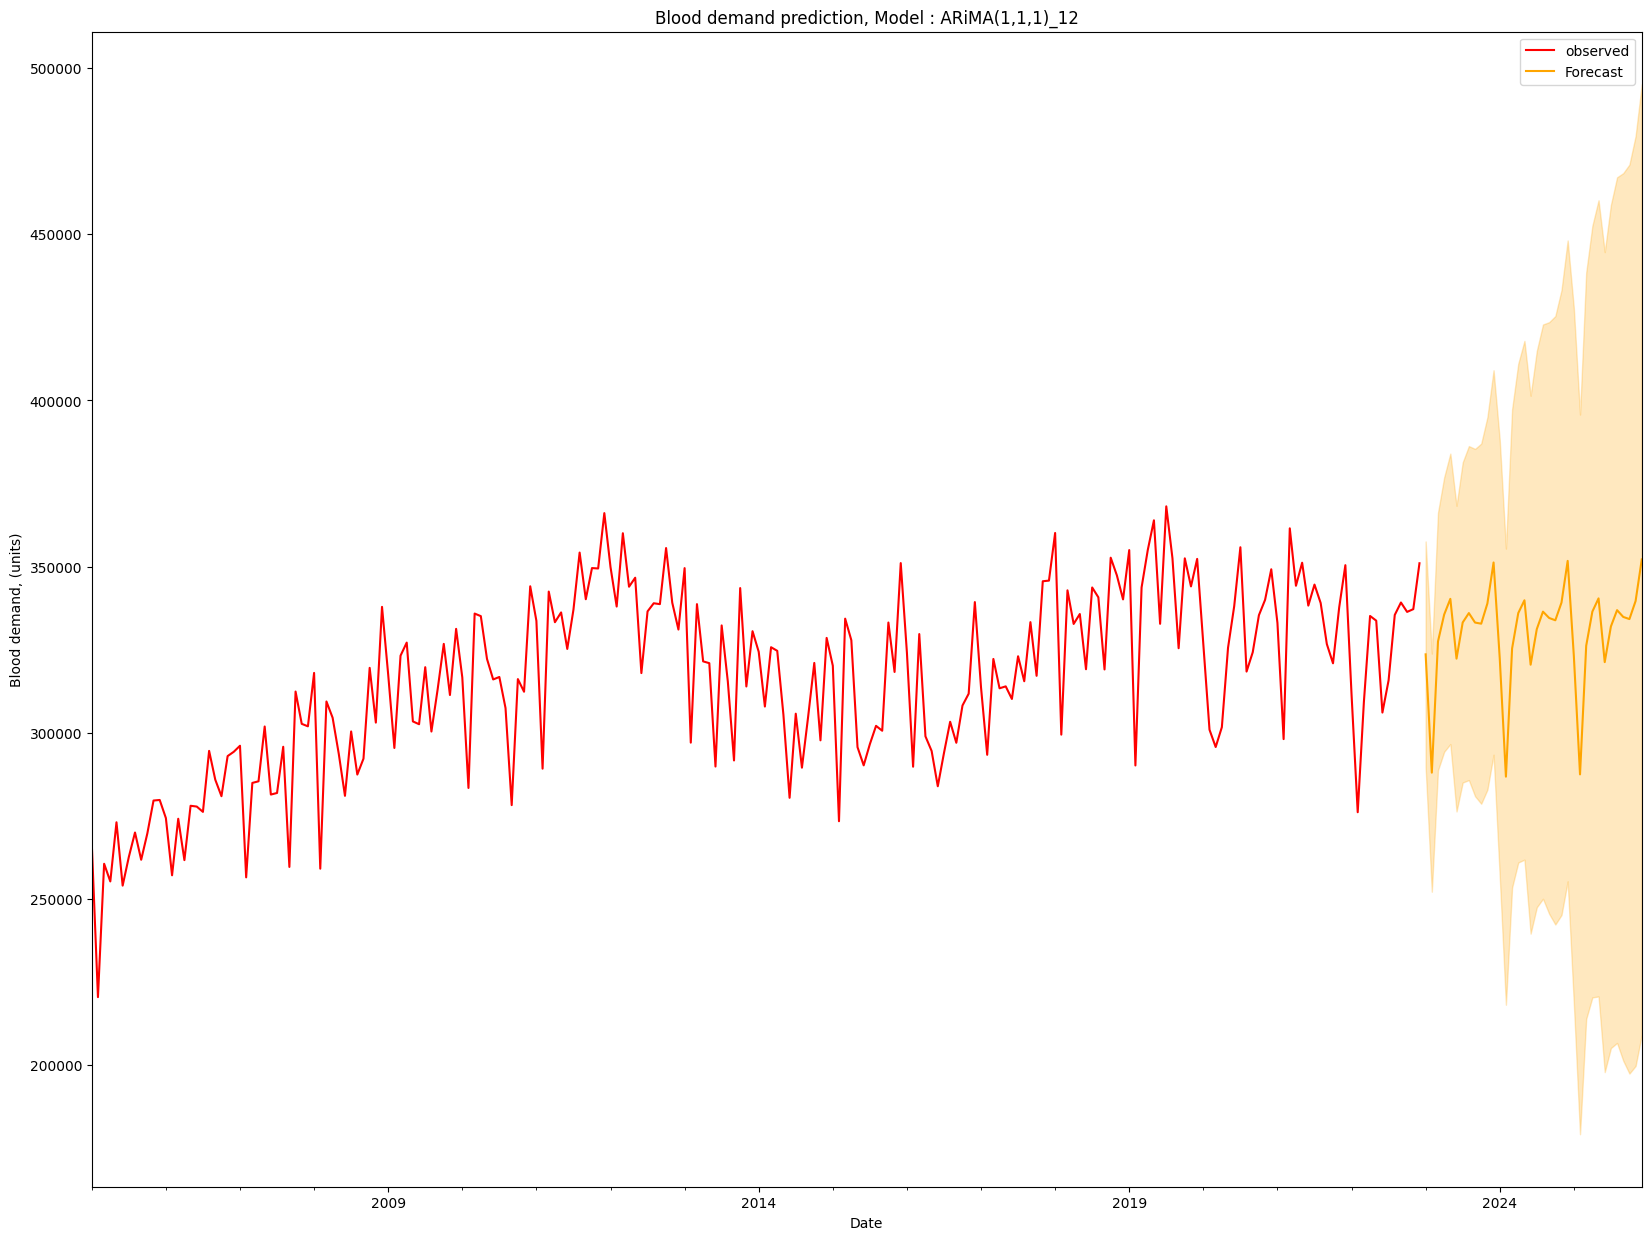

In [ ]:
# Get forecast 12*3 steps ahead in future
pred_uc = results.get_forecast(steps=(12*3))

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = df_t.plot(label='observed', figsize=(20, 15),color='red')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast',color = 'orange')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='orange', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Blood demand, (units)')

plt.title('Blood demand prediction, Model : ARiMA(1,1,1)_12')
plt.legend()
#plt.show()
plt.savefig('Blood demand prediction.png')

공급(헌혈자수) 분석

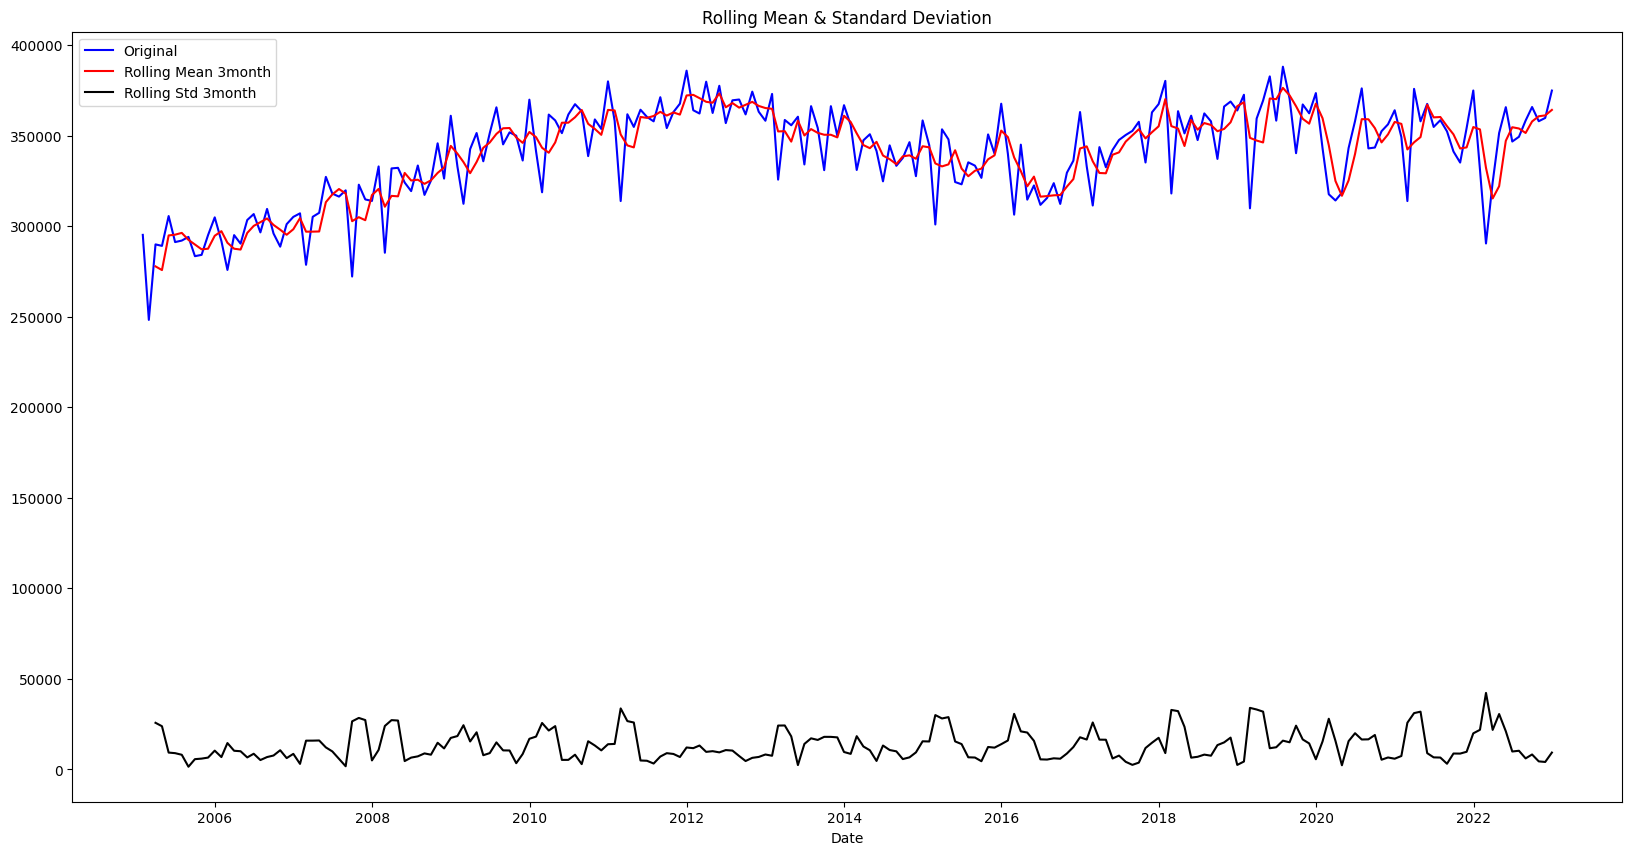

In [ ]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean {}month'.format(interval))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std {}month'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
df_supply = df['혈액공급']
plot_rolling(df_supply,3)

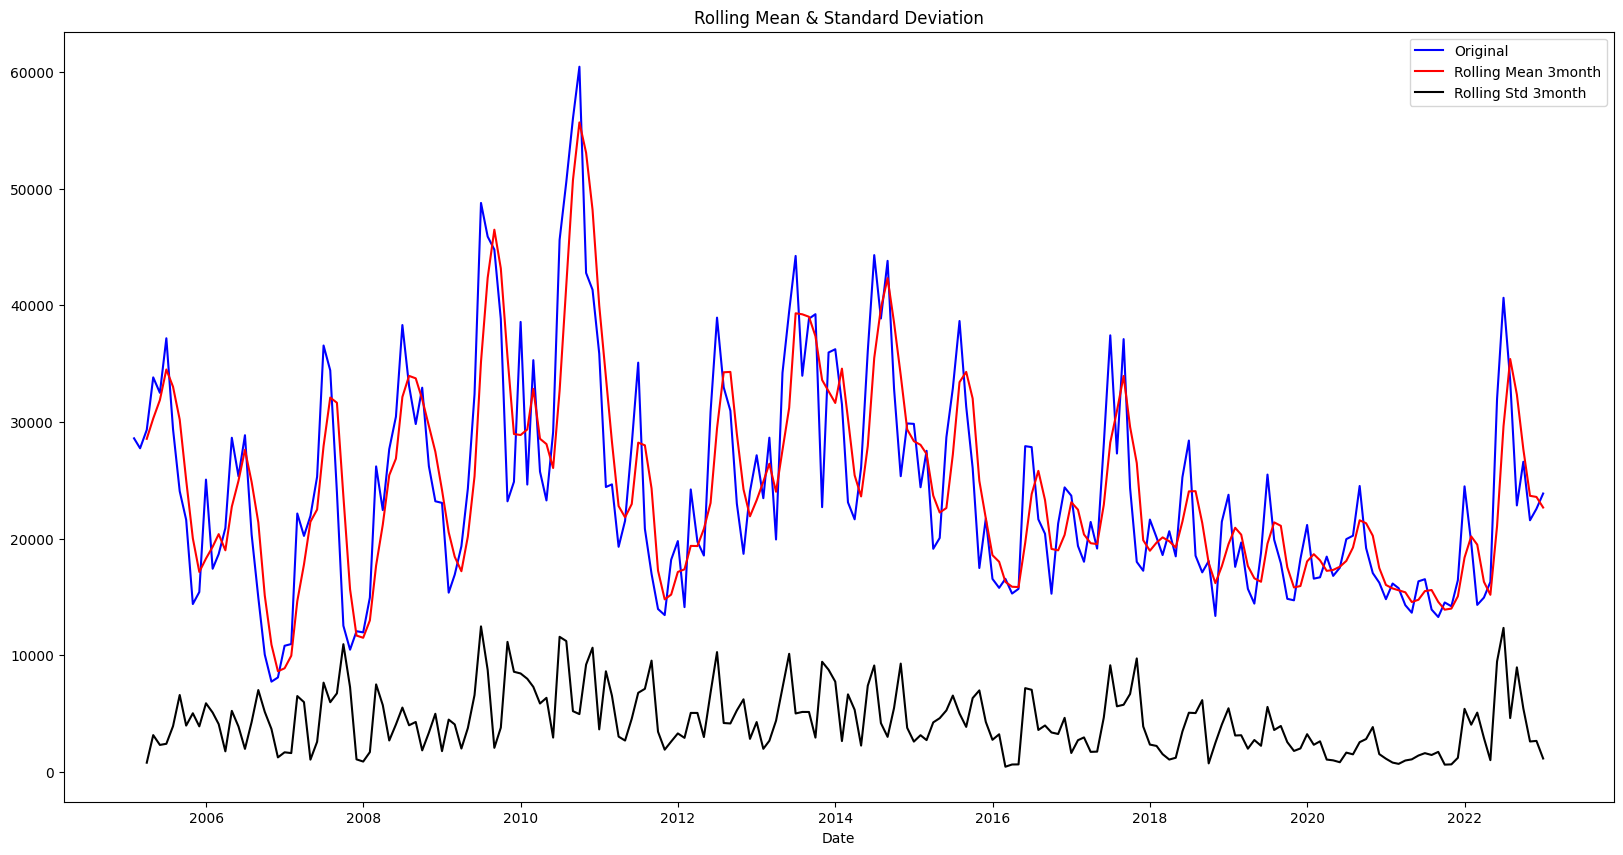

In [ ]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean {}month'.format(interval))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std {}month'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
df_have = df['혈액보유']
plot_rolling(df_have,3)

현재 헌혈의 수요는 거의 일정해보인다. 다만 계절적 요인이 크게 작용함을 볼 수 있다.(여름, 겨울)

이에 헌혈의 공급지표를 살펴보려 한다. 주로 공급의 불안함으로 꼽는 것이 인구의 초고령화 사회 진입

그러므로 먼저 연령대별,성별 헌혈참가 자료를 통하여 헌혈자료 학습(성별로도 크게 나뉘는 것을 알 수 있다.)

헌혈인구 학습

In [ ]:
bddo = pd.read_csv('C:/Users/galax/Downloads/bddo.csv',encoding='EUC-KR')
bddo.tail()

,16~19세,20~29세,30~39세,40~49세,50~59세,60세이상
13,853433,1119821,427926,328103,130933,23054
14,800321,1017604,431188,358446,155645,27888
15,509626,945115,450991,445991,222222,37456
16,544176,918066,423354,440457,235723,42661
17,462186,970120,439078,463883,262920,50820


In [ ]:
bddo['date'] = pd.date_range('2005-01', periods=(18), freq='Y')
bddo = bddo.set_index("date")

bddo['15-24'] = bddo['16~19세'] + abs(bddo['20~29세']/2)
bddo['25-49'] = bddo['30~39세'] + abs(bddo['20~29세']/2) + bddo['40~49세']
bddo['50+'] = bddo['50~59세'] + bddo['60세이상']

bddo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18 entries, 2005-12-31 to 2022-12-31
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   16~19세  18 non-null     int64  
 1   20~29세  18 non-null     int64  
 2   30~39세  18 non-null     int64  
 3   40~49세  18 non-null     int64  
 4   50~59세  18 non-null     int64  
 5   60세이상   18 non-null     int64  
 6   15-24   18 non-null     float64
 7   25-49   18 non-null     float64
 8   50+     18 non-null     int64  
dtypes: float64(2), int64(7)
memory usage: 1.4 KB


In [ ]:
bddo = bddo[['15-24', '25-49','50+']]
bddo

,15-24,25-49,50+
date,,,
2005-12-31,1287225.0,960526.0,26585
2006-12-31,1328671.5,943371.5,30499
2007-12-31,1212111.0,844616.0,31035
2008-12-31,1372255.5,936097.5,38831
2009-12-31,1465892.0,1054570.0,49492
2010-12-31,1576652.5,1033169.5,54670
2011-12-31,1571791.5,986430.5,58353
2012-12-31,1595898.5,1060641.5,66068
2013-12-31,1674701.5,1164706.5,75075


In [ ]:
bdpossible = pd.read_csv('C:/Users/galax/Downloads/bdpossible.csv',encoding='EUC-KR')
bdpossible['date'] = pd.date_range('2005-01', periods=(56), freq='Y')
bdpossible = bdpossible.set_index("date")
bdpossible = bdpossible*1000
bdpossible['50세+'] = bdpossible['50-64세']+bdpossible['65세+']
bdpossible = bdpossible[['15-24세', '25-49세', '50세+']]
bdpossible.tail()

,15-24세,25-49세,50세+
date,,,
2056-12-31,3201000,9694000,28123000
2057-12-31,3172000,9553000,27885000
2058-12-31,3133000,9390000,27668000
2059-12-31,3088000,9265000,27417000
2060-12-31,3037000,9148000,27158000


In [ ]:
bdpossiblec = bdpossible.iloc[0:18]

df_merge = pd.concat([bddo, bdpossiblec], axis=1)
df_merge

,15-24,25-49,50+,15-24세,25-49세,50세+
date,,,,,,
2005-12-31,1287225.0,960526.0,26585,6869000,20678000,11415000
2006-12-31,1328671.5,943371.5,30499,6690000,20839000,11930000
2007-12-31,1212111.0,844616.0,31035,6565000,20952000,12453000
2008-12-31,1372255.5,936097.5,38831,6509000,21011000,13056000
2009-12-31,1465892.0,1054570.0,49492,6522000,20890000,13667000
2010-12-31,1576652.5,1033169.5,54670,6568000,20677000,14330000
2011-12-31,1571791.5,986430.5,58353,6644000,20474000,15047000
2012-12-31,1595898.5,1060641.5,66068,6705000,20269000,15650000
2013-12-31,1674701.5,1164706.5,75075,6744000,20005000,16289000


df_merge에서 연령별 추정을 따로 따로 한다. y(헌혈횟수) = a + b*x(헌혈가능인구)

15~24 연령층의 헌혈자에 대한 회귀예측

In [ ]:
X = df_merge.iloc[:,3]
y = df_merge.iloc[:,0]

In [ ]:
y = y.values.reshape(18, 1)
y.shape

(18, 1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add( Dense(units=5, activation='relu', input_shape=( 1 , )) )
model.add( Dense(units=15, activation='relu') )
model.add( Dense(units=10, activation='relu') )
model.add( Dense(units=1, activation='linear') )

model.compile(loss='mse', optimizer='adam')

In [ ]:
epoch_history = model.fit(X, y, epochs=1000, batch_size=10)

Epoch 1/1000


2/2 [==============================] - 1s 8ms/step - loss: 2513200742400.0000
Epoch 2/1000
2/2 [==============================] - 0s 8ms/step - loss: 2207403212800.0000
Epoch 3/1000
2/2 [==============================] - 0s 8ms/step - loss: 1933476626432.0000
Epoch 4/1000
2/2 [==============================] - 0s 0s/step - loss: 1677106741248.0000
Epoch 5/1000
2/2 [==============================] - 0s 0s/step - loss: 1438875385856.0000
Epoch 6/1000
2/2 [==============================] - 0s 0s/step - loss: 1214378541056.0000
Epoch 7/1000
2/2 [==============================] - 0s 8ms/step - loss: 1024708050944.0000
Epoch 8/1000
2/2 [==============================] - 0s 0s/step - loss: 842613915648.0000
Epoch 9/1000
2/2 [==============================] - 0s 0s/step - loss: 686306164736.0000
Epoch 10/1000
2/2 [==============================] - 0s 8ms/step - loss: 553845719040.0000
Epoch 11/1000
2/2 [==============================] - 0s 8ms/step - loss: 434197495808.0000
Epoch 12/1000
2/2 [

In [ ]:
X1 = bdpossible.iloc[:,0]

y_pred = model.predict(X1)


2/2 [==============================] - 0s 0s/step


In [ ]:
newdf=pd.DataFrame(y_pred)
newdf['date'] = pd.date_range('2005-01', periods=(56), freq='Y')
newdf = newdf.set_index("date")

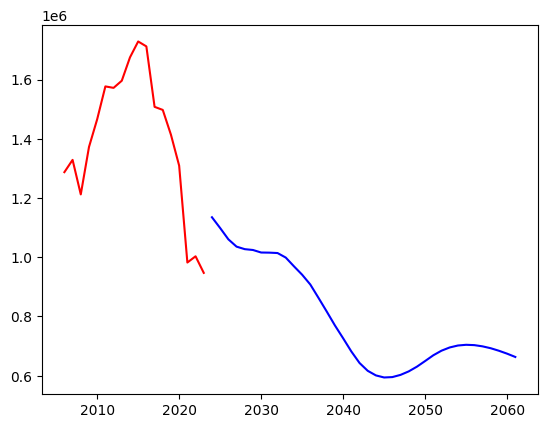

In [ ]:
import matplotlib.pyplot as plt
y1 = df_merge.iloc[:,0]
plt.plot(y1, c='r') # 실제값은 빨간선
plt.plot(newdf.iloc[18:,], c='b') # 예측값은 파란선
plt.show()

25-49 연령층의 헌혈자에 대한 회귀예측

In [ ]:
X = df_merge.iloc[:,4]
y = df_merge.iloc[:,1]

In [ ]:
y = y.values.reshape(18, 1)
y.shape

(18, 1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add( Dense(units=5, activation='relu', input_shape=( 1 , )) )
model.add( Dense(units=15, activation='relu') )
model.add( Dense(units=10, activation='relu') )
model.add( Dense(units=1, activation='linear') )

model.compile(loss='mse', optimizer='adam')

In [ ]:
epoch_history = model.fit(X, y, epochs=1000, batch_size=10)

Epoch 1/1000


2/2 [==============================] - 1s 8ms/step - loss: 28164508090368.0000
Epoch 2/1000
2/2 [==============================] - 0s 8ms/step - loss: 24238077509632.0000
Epoch 3/1000
2/2 [==============================] - 0s 8ms/step - loss: 20683883020288.0000
Epoch 4/1000
2/2 [==============================] - 0s 0s/step - loss: 17495625826304.0000
Epoch 5/1000
2/2 [==============================] - 0s 8ms/step - loss: 14572042846208.0000
Epoch 6/1000
2/2 [==============================] - 0s 8ms/step - loss: 11771379187712.0000
Epoch 7/1000
2/2 [==============================] - 0s 8ms/step - loss: 9241737822208.0000
Epoch 8/1000
2/2 [==============================] - 0s 8ms/step - loss: 7015599439872.0000
Epoch 9/1000
2/2 [==============================] - 0s 8ms/step - loss: 5184912097280.0000
Epoch 10/1000
2/2 [==============================] - 0s 0s/step - loss: 3658561093632.0000
Epoch 11/1000
2/2 [==============================] - 0s 8ms/step - loss: 2471634403328.0000
Epoch 

In [ ]:
X1 = bdpossible.iloc[:,1]

y_pred = model.predict(X1)

2/2 [==============================] - 0s 0s/step


In [ ]:
newdf=pd.DataFrame(y_pred)
newdf['date'] = pd.date_range('2005-01', periods=(56), freq='Y')
newdf = newdf.set_index("date")

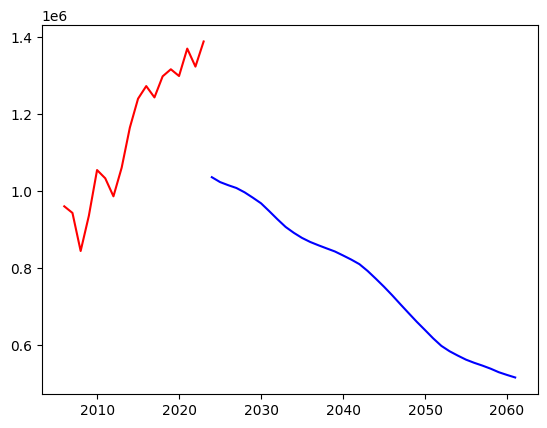

In [ ]:
import matplotlib.pyplot as plt
y1 = df_merge.iloc[:,1]
plt.plot(y1, c='r') # 실제값은 빨간선
plt.plot(newdf.iloc[18:,], c='b') # 예측값은 파란선
plt.show()

50+ 연령층의 헌혈자에 대한 회귀예측

In [ ]:
X = df_merge.iloc[:,5]
y = df_merge.iloc[:,2]

In [ ]:
y = y.values.reshape(18, 1)
y.shape

(18, 1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add( Dense(units=5, activation='relu', input_shape=( 1 , )) )
model.add( Dense(units=15, activation='relu') )
model.add( Dense(units=10, activation='relu') )
model.add( Dense(units=1, activation='linear') )

model.compile(loss='mse', optimizer='adam')

In [ ]:
epoch_history = model.fit(X, y, epochs=1000, batch_size=10)

Epoch 1/1000
2/2 [==============================] - 1s 0s/step - loss: 9265876041728.0000
Epoch 2/1000
2/2 [==============================] - 0s 0s/step - loss: 8223733579776.0000
Epoch 3/1000
2/2 [==============================] - 0s 0s/step - loss: 7363191898112.0000
Epoch 4/1000
2/2 [==============================] - 0s 0s/step - loss: 6576595271680.0000
Epoch 5/1000
2/2 [==============================] - 0s 0s/step - loss: 5850710147072.0000
Epoch 6/1000
2/2 [==============================] - 0s 8ms/step - loss: 5166567260160.0000
Epoch 7/1000
2/2 [==============================] - 0s 8ms/step - loss: 4537020055552.0000
Epoch 8/1000
2/2 [==============================] - 0s 0s/step - loss: 3968370737152.0000
Epoch 9/1000
2/2 [==============================] - 0s 0s/step - loss: 3459535077376.0000
Epoch 10/1000
2/2 [==============================] - 0s 0s/step - loss: 2976346537984.0000
Epoch 11/1000
2/2 [==============================] - 0s 0s/step - loss: 2549003583488.0000
Epoch 

In [ ]:
X1 = bdpossible.iloc[:,2]

y_pred = model.predict(X1)

2/2 [==============================] - 0s 0s/step


In [ ]:
newdf=pd.DataFrame(y_pred)
newdf['date'] = pd.date_range('2005-01', periods=(56), freq='Y')
newdf = newdf.set_index("date")

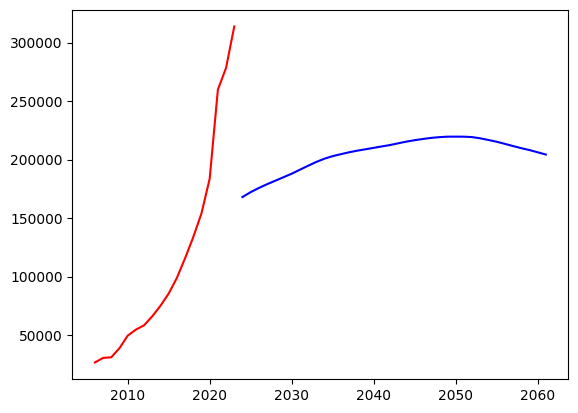

In [ ]:
import matplotlib.pyplot as plt
y1 = df_merge.iloc[:,2]
plt.plot(y1, c='r') # 실제값은 빨간선
plt.plot(newdf.iloc[18:,], c='b') # 예측값은 파란선
plt.show()